In [1]:
import torch

sentences = ["Kage is Teacher", "Mazong is Boss", "Niuzong is Boss", "Xiaobing is Student", "Xiaoxue is Student"]
words = ' '.join(sentences).split()
# 去除重复单词
word_list = list(set(words))

word_to_idx = {word: idx for idx, word in enumerate(word_list)}
idx_to_word = {idx: word for idx, word in enumerate(word_list)}
# print(word_to_idx)
# print(idx_to_word)
voc_size = len(word_list)
print("词汇表", word_list)
print("词汇到索引", word_to_idx)
print("索引到词汇", idx_to_word)
print("词汇表大小", voc_size)

词汇表 ['Boss', 'Mazong', 'Xiaoxue', 'Teacher', 'Kage', 'Student', 'is', 'Xiaobing', 'Niuzong']
词汇到索引 {'Boss': 0, 'Mazong': 1, 'Xiaoxue': 2, 'Teacher': 3, 'Kage': 4, 'Student': 5, 'is': 6, 'Xiaobing': 7, 'Niuzong': 8}
索引到词汇 {0: 'Boss', 1: 'Mazong', 2: 'Xiaoxue', 3: 'Teacher', 4: 'Kage', 5: 'Student', 6: 'is', 7: 'Xiaobing', 8: 'Niuzong'}
词汇表大小 9


In [3]:
# 获取相邻的单词，将当前单词前后各N个单词作为周围词
def create_skipgram_dataset(sentences, window_size=2):
    # print(window_size)
    data = []
    for sentence in sentences:
        sentence = sentence.split()
        for idx, word in enumerate(sentence):
            for neighbor in sentence[max(idx-window_size, 0):min(idx+window_size+1, len(sentence))]:
                # print(word,"=", neighbor)
                if neighbor != word:
                    data.append((neighbor, word))
    return data

skipgram_data = create_skipgram_dataset(sentences, window_size=2)
print("Skip-Gram数据样例:", skipgram_data[:3])

Skip-Gram数据样例: [('is', 'Kage'), ('Teacher', 'Kage'), ('Kage', 'is')]


In [4]:
import torch.nn as nn
class SkipGram(nn.Module):
    def __init__(self, voc_size, embedding_size):
        super(SkipGram, self).__init__()
        # 从词汇表大小到嵌入层大小的线性层
        self.input_to_hidden = nn.Embedding(voc_size, embedding_size)
        # 从嵌入层大小到词汇表大小的线性层
        self.hidden_to_output = nn.Linear(embedding_size, voc_size, bias=False)

    def forward(self, X):
        hidden = self.input_to_hidden(X) # [batch_size, embedding_size]
        output = self.hidden_to_output(hidden) # [batch_size, voc_size]
        return output

Skip-Gram类 SkipGram(
  (input_to_hidden): Embedding(9, 2)
  (hidden_to_output): Linear(in_features=2, out_features=9, bias=False)
)
Epoch 100, Loss: 2.125421333312988
Epoch 200, Loss: 2.0841748833656313
Epoch 300, Loss: 2.0462948441505433
Epoch 400, Loss: 2.006737740834554
Epoch 500, Loss: 1.9639696915944418
Epoch 600, Loss: 1.9201043168703715
Epoch 700, Loss: 1.879391904671987
Epoch 800, Loss: 1.8443417688210806
Epoch 900, Loss: 1.814352379242579
Epoch 1000, Loss: 1.7877797226111094


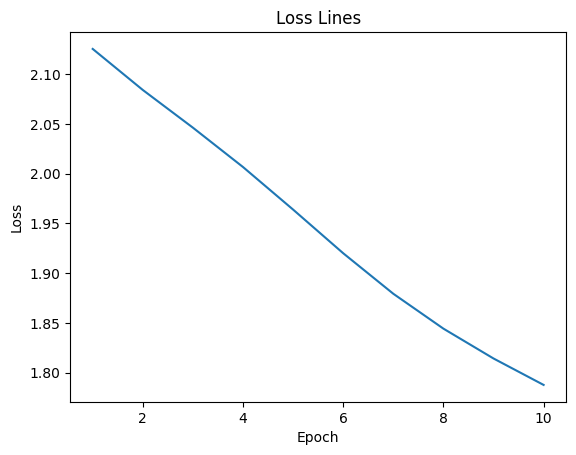

In [8]:
embedding_size=2 #嵌入层大小
skipgram_model = SkipGram(voc_size, embedding_size)
print("Skip-Gram类", skipgram_model)

learning_rate = 0.001 
epoches = 1000
loss_fn = nn.CrossEntropyLoss()
import torch.optim as optim
optimizer = optim.SGD(skipgram_model.parameters(), lr=learning_rate)

loss_values = []
for epoch in range(epoches):
    loss_sum = 0
    for context, target in skipgram_data:
        # **skip-gram用中心词预测周围词**
        X = torch.tensor([word_to_idx[target]], dtype=torch.long)
        # print(X.shape)
        y_true = torch.tensor([word_to_idx[context]], dtype=torch.long)
        # print(y_true.shape)
        y_pred = skipgram_model(X)
        # print(y_pred.shape)
        loss = loss_fn(y_pred, y_true)
        loss_sum += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if (epoch + 1) % 100 == 0:
        cur_loss = loss_sum/len(skipgram_data)
        print(f"Epoch {epoch+1}, Loss: {cur_loss}")
        loss_values.append(cur_loss)

import matplotlib.pyplot as plt

plt.plot(range(1, epoches//100 + 1), loss_values)
plt.title("Loss Lines")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

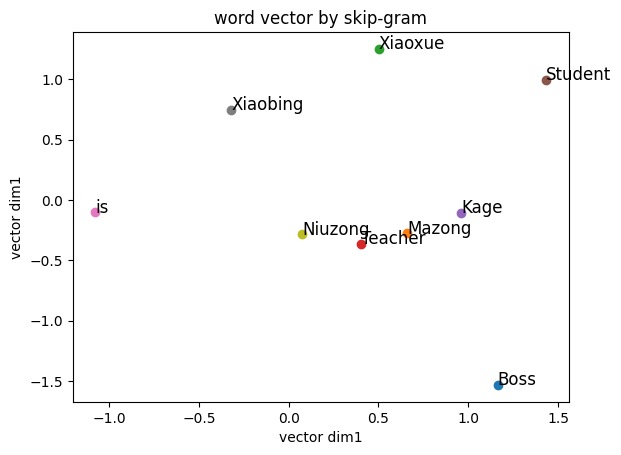

In [9]:
fig, ax = plt.subplots()
for word, idx in word_to_idx.items():
    vec = skipgram_model.input_to_hidden.weight[idx].detach().numpy()
    ax.scatter(vec[0], vec[1]) # 绘制向量
    ax.annotate(word, (vec[0], vec[1]), fontsize=12) # 标注单词
plt.title("word vector by skip-gram")
plt.xlabel("vector dim1")
plt.ylabel("vector dim1")
plt.show()